In [ ]:
#importing bunch of libraries that would be needed in future
import pandas as pd
import numpy as np
import gc,os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import pickle
import lightgbm as lgb
from sklearn.metrics import roc_auc_score,precision_score,recall_score,f1_score,confusion_matrix

from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir('/content/gdrive/My Drive/santander_transcation_prediction')

### Data loading & splitting

In [ ]:
#train
df=pd.read_csv("train.csv.zip")
X=df.drop(['ID_code','target'],axis=1)
Y=df['target']
del df;

#test
df_subm=pd.read_csv("test.csv.zip")
X_subm=df_subm.drop('ID_code',axis=1)
del df_subm


In [ ]:
# splitting data to train(0.8) and test(0.2)
X_train,X_test,Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)

In [ ]:
#shape
X_train.shape,X_test.shape

((160000, 200), (40000, 200))

In [ ]:
#splitting train set into d1(0.5) & d2(0.5)
X_d1,X_d2,Y_d1,y_d2=train_test_split(X_train,Y_train,test_size=0.5,random_state=42, stratify=Y_train)

In [ ]:
#shape
X_d1.shape,Y_d1.shape

((80000, 200), (80000,))

### Custom ensemble model bulding k=20

In [ ]:
clf=DecisionTreeClassifier()

In [ ]:
k=20
fraction=0.3

In [ ]:

pred_score=np.zeros((len(X_d2),k))
pred_score_test=np.zeros((len(X_test),k))
pred_score_submission=np.zeros((len(X_subm),k))
for i in range(k):
  #generating  sample
  X_data=X_d1.sample(frac=fraction)
  Y_data=Y_d1[X_data.index]

  #training
  clf.fit(X_data,Y_data)

  #predicting 
  pred_score[:,i]=clf.predict(X_d2)
  pred_score_test[:,i]=clf.predict(X_test)

  pred_score_submission[:,i]=clf.predict_proba(X_subm)[:,1]


  



In [ ]:
pred_score.shape,pred_score_test.shape,pred_score_submission.shape

((80000, 20), (40000, 20), (200000, 20))

In [ ]:
#meta model =LogisticRegression
clf_meta=LogisticRegression()
clf_meta.fit(pred_score,y_d2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
test_score_label=clf_meta.predict(pred_score_test)
test_score_proba=clf_meta.predict_proba(pred_score_test)[:,1]

auc=roc_auc_score(Y_test,test_score_proba)
print('auc_score:',auc)


cm=confusion_matrix(Y_test, test_score_label)
print('conf_matrix:')
print(cm)


recall=recall_score(Y_test, test_score_label)
print("Recall Score :",recall)

f1=f1_score(Y_test, test_score_label)
print("F1 score Score :",f1)



auc_score: 0.7395740931252576
conf_matrix:
[[35776   204]
 [ 3774   246]]
Recall Score : 0.06119402985074627
F1 score Score : 0.11006711409395972


**Kaggle score**

In [ ]:
test_score_subm=clf_meta.predict_proba(pred_score_submission)[:,1]

ID_code=[f'test_{i}' for i in range(200000)]
d={'ID_code':ID_code,'target':test_score_subm}
submission=pd.DataFrame(data=d)

submission.to_csv("STP_custom_ensemble/custom_ensemble_k_20_LR.csv",index=False)

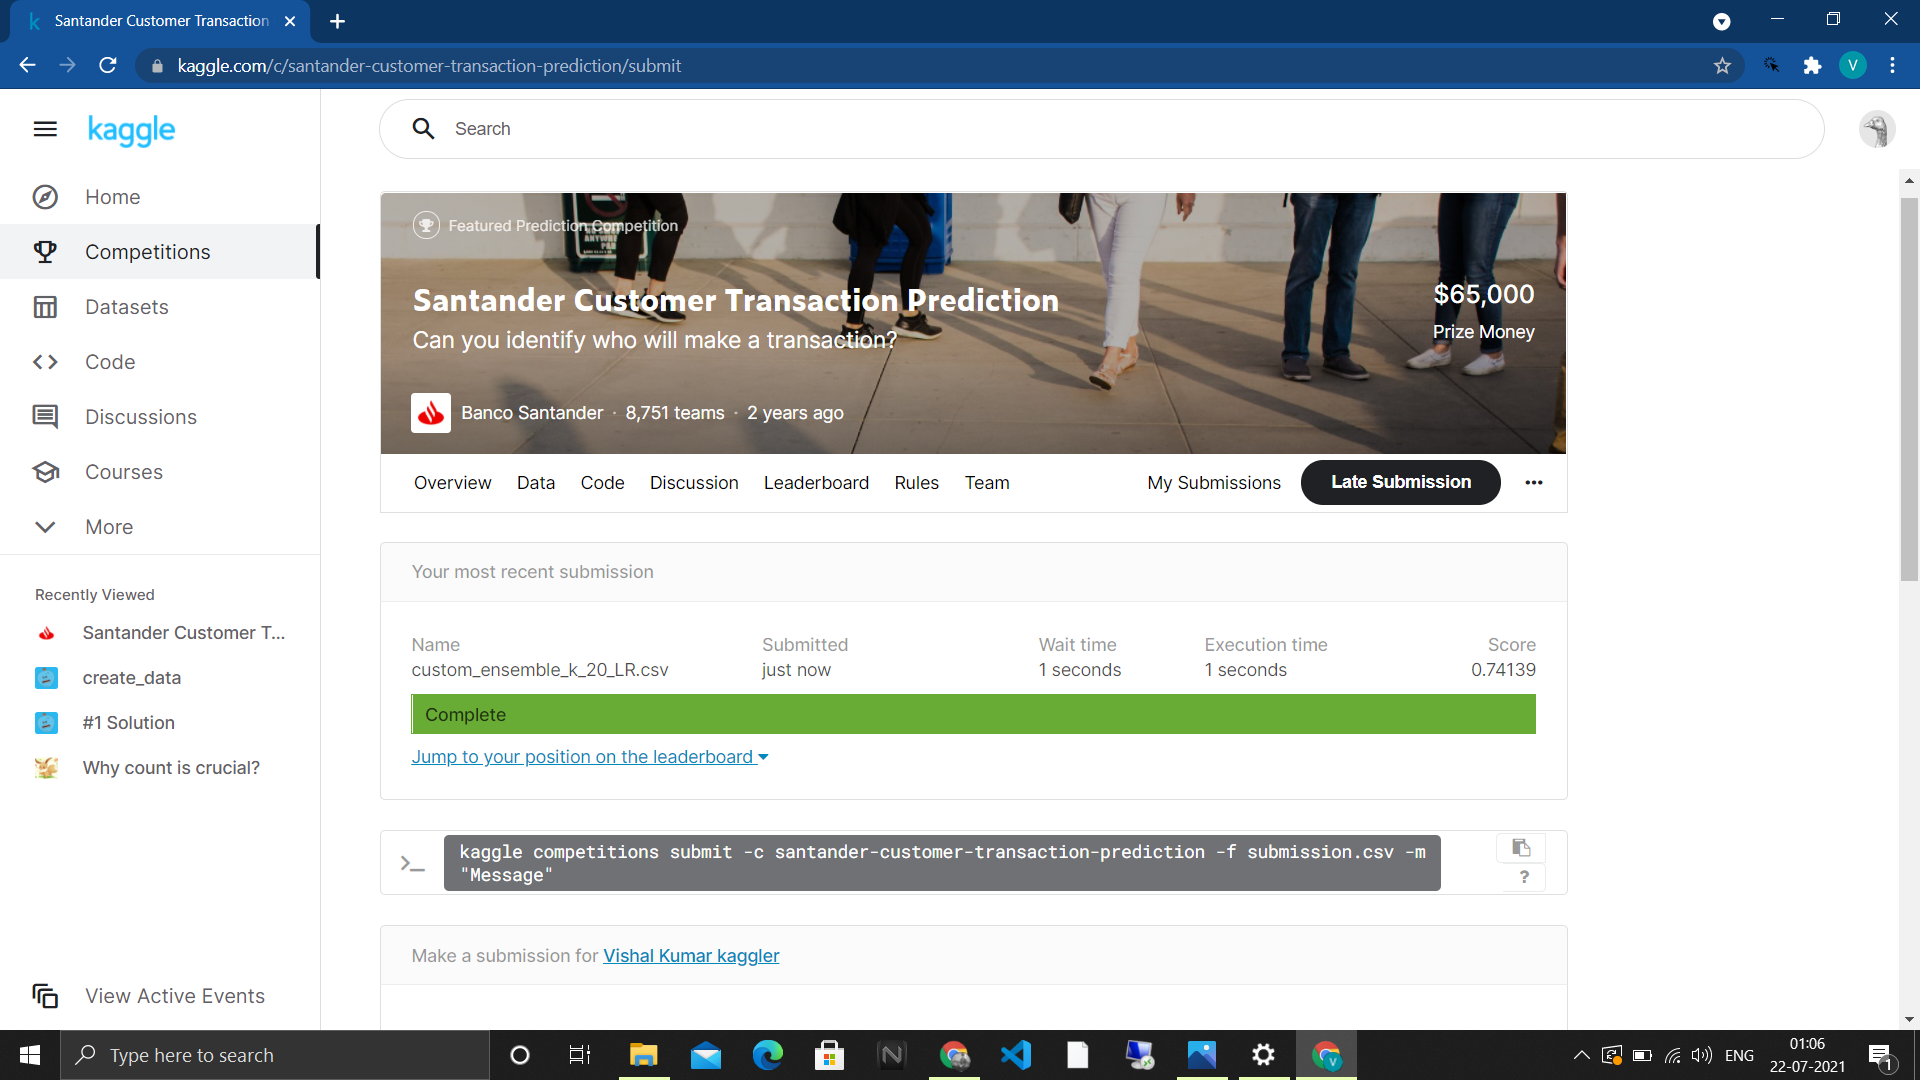

### Custom ensemble model bulding k=50

In [ ]:
clf=DecisionTreeClassifier()

In [ ]:
k=50
fraction=0.3

In [ ]:

pred_score=np.zeros((len(X_d2),k))
pred_score_test=np.zeros((len(X_test),k))
pred_score_submission=np.zeros((len(X_subm),k))
for i in range(k):
  #generating  sample
  X_data=X_d1.sample(frac=fraction)
  Y_data=Y_d1[X_data.index]

  #training
  clf.fit(X_data,Y_data)

  #predicting 
  pred_score[:,i]=clf.predict(X_d2)
  pred_score_test[:,i]=clf.predict(X_test)

  pred_score_submission[:,i]=clf.predict(X_subm)
  



In [ ]:
#meta model =LogisticRegression
clf_meta=LogisticRegression()
clf_meta.fit(pred_score,y_d2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
test_score_label=clf_meta.predict(pred_score_test)
test_score_proba=clf_meta.predict_proba(pred_score_test)[:,1]

auc=roc_auc_score(Y_test,test_score_proba)
print('auc_score:',auc)


cm=confusion_matrix(Y_test, test_score_label)
print('conf_matrix:')
print(cm)


recall=recall_score(Y_test, test_score_label)
print("Recall Score :",recall)

f1=f1_score(Y_test, test_score_label)
print("F1 score Score :",f1)



auc_score: 0.7783901296740312
conf_matrix:
[[35611   369]
 [ 3576   444]]
Recall Score : 0.11044776119402985
F1 score Score : 0.18373680943513346


**Kaggle submission**

In [ ]:
test_score_subm=clf_meta.predict_proba(pred_score_submission)[:,1]

ID_code=[f'test_{i}' for i in range(200000)]
d={'ID_code':ID_code,'target':test_score_subm}
submission=pd.DataFrame(data=d)

submission.to_csv("STP_custom_ensemble/custom_ensemble_k_50_LR.csv",index=False)

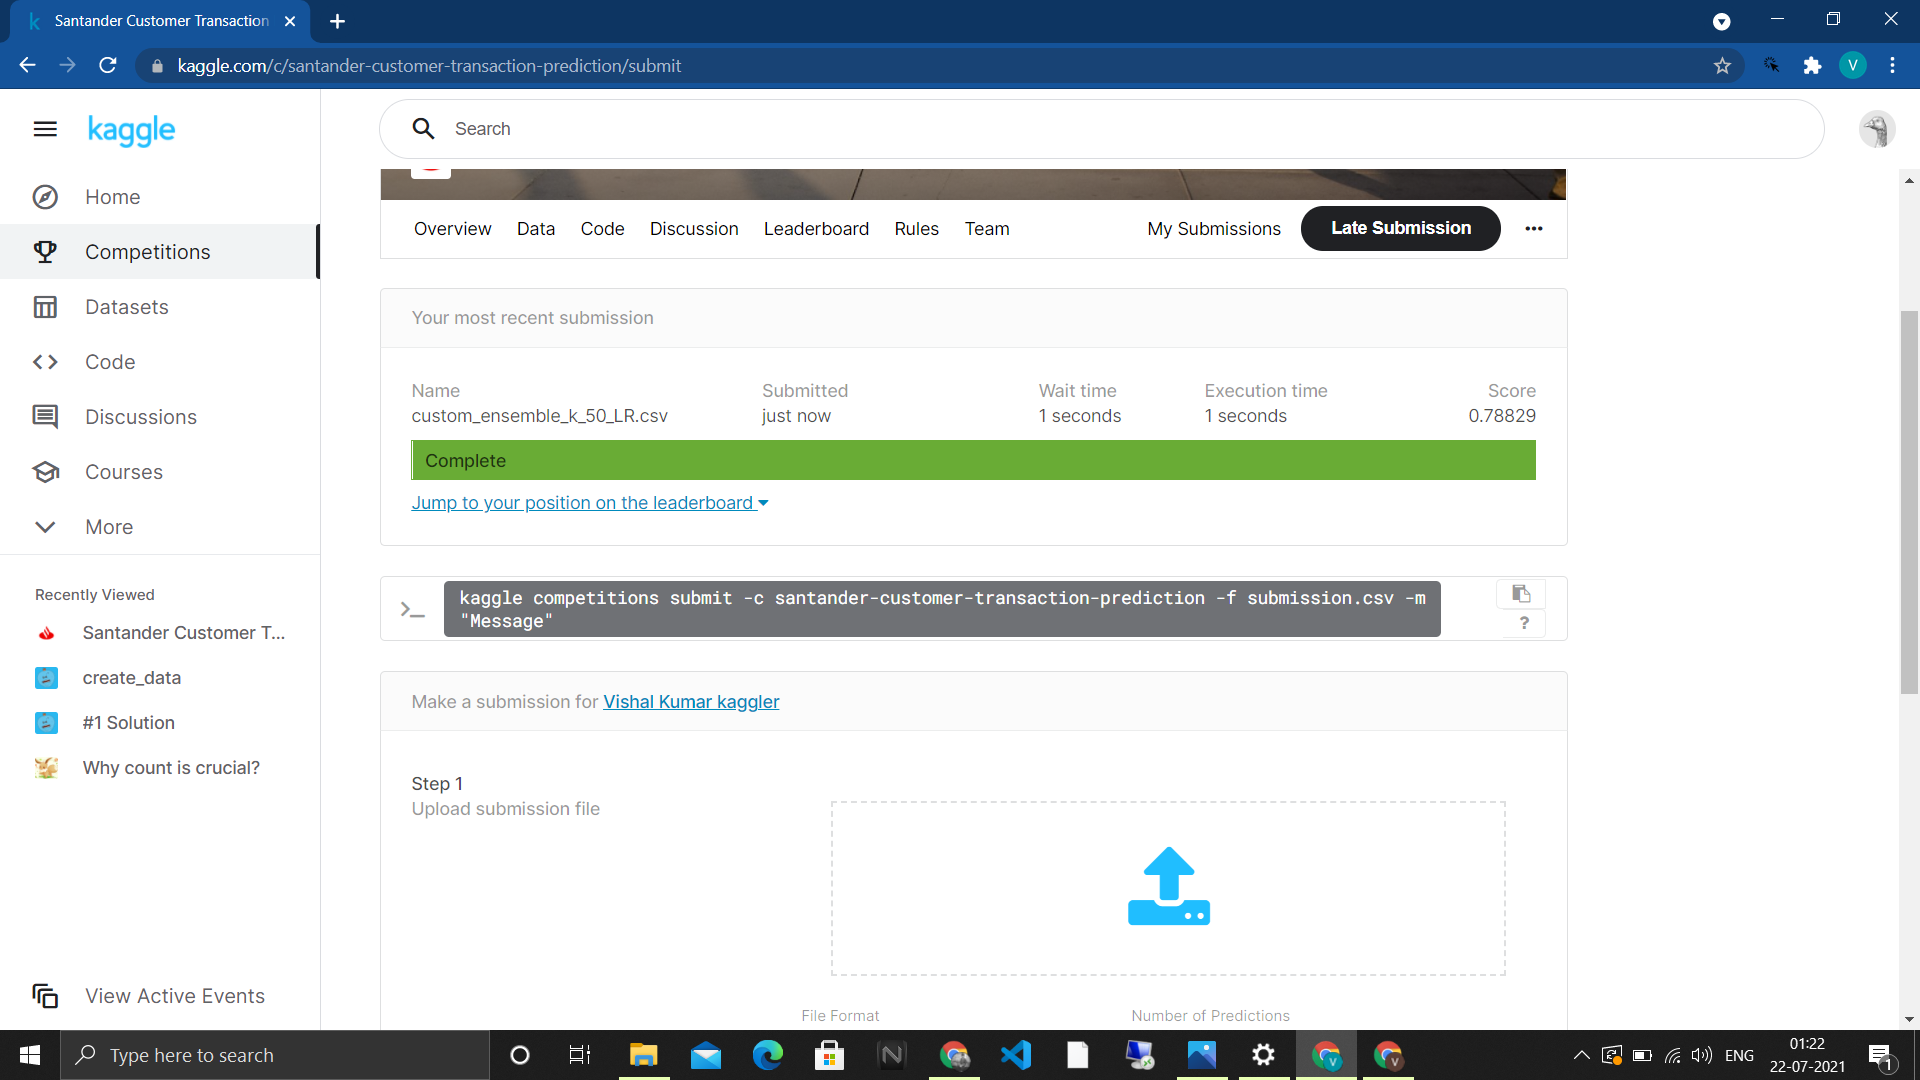

### Custom ensemble model bulding k=100

In [ ]:
clf=DecisionTreeClassifier()

In [ ]:
k=100
fraction=0.3

In [ ]:

pred_score=np.zeros((len(X_d2),k))
pred_score_test=np.zeros((len(X_test),k))
pred_score_submission=np.zeros((len(X_subm),k))
for i in range(k):
  #generating  sample
  X_data=X_d1.sample(frac=fraction)
  Y_data=Y_d1[X_data.index]

  #training
  clf.fit(X_data,Y_data)

  #predicting 
  pred_score[:,i]=clf.predict(X_d2)
  pred_score_test[:,i]=clf.predict(X_test)

  pred_score_submission[:,i]=clf.predict_proba(X_subm)[:,1]


  



In [ ]:
pred_score.shape,pred_score_test.shape,pred_score_submission.shape

((80000, 100), (40000, 100), (200000, 100))

In [ ]:
#meta model =LogisticRegression
clf_meta=LogisticRegression()
clf_meta.fit(pred_score,y_d2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
test_score_label=clf_meta.predict(pred_score_test)
test_score_proba=clf_meta.predict_proba(pred_score_test)[:,1]

auc=roc_auc_score(Y_test,test_score_proba)
print('auc_score:',auc)


cm=confusion_matrix(Y_test, test_score_label)
print('conf_matrix:')
print(cm)


recall=recall_score(Y_test, test_score_label)
print("Recall Score :",recall)

f1=f1_score(Y_test, test_score_label)
print("F1 score Score :",f1)



auc_score: 0.7998101730093281
conf_matrix:
[[35582   398]
 [ 3456   564]]
Recall Score : 0.14029850746268657
F1 score Score : 0.22641509433962265


**Kaggle score**

In [ ]:
test_score_subm=clf_meta.predict_proba(pred_score_submission)[:,1]

ID_code=[f'test_{i}' for i in range(200000)]
d={'ID_code':ID_code,'target':test_score_subm}
submission=pd.DataFrame(data=d)

submission.to_csv("STP_custom_ensemble/custom_ensemble_k_100_LR.csv",index=False)

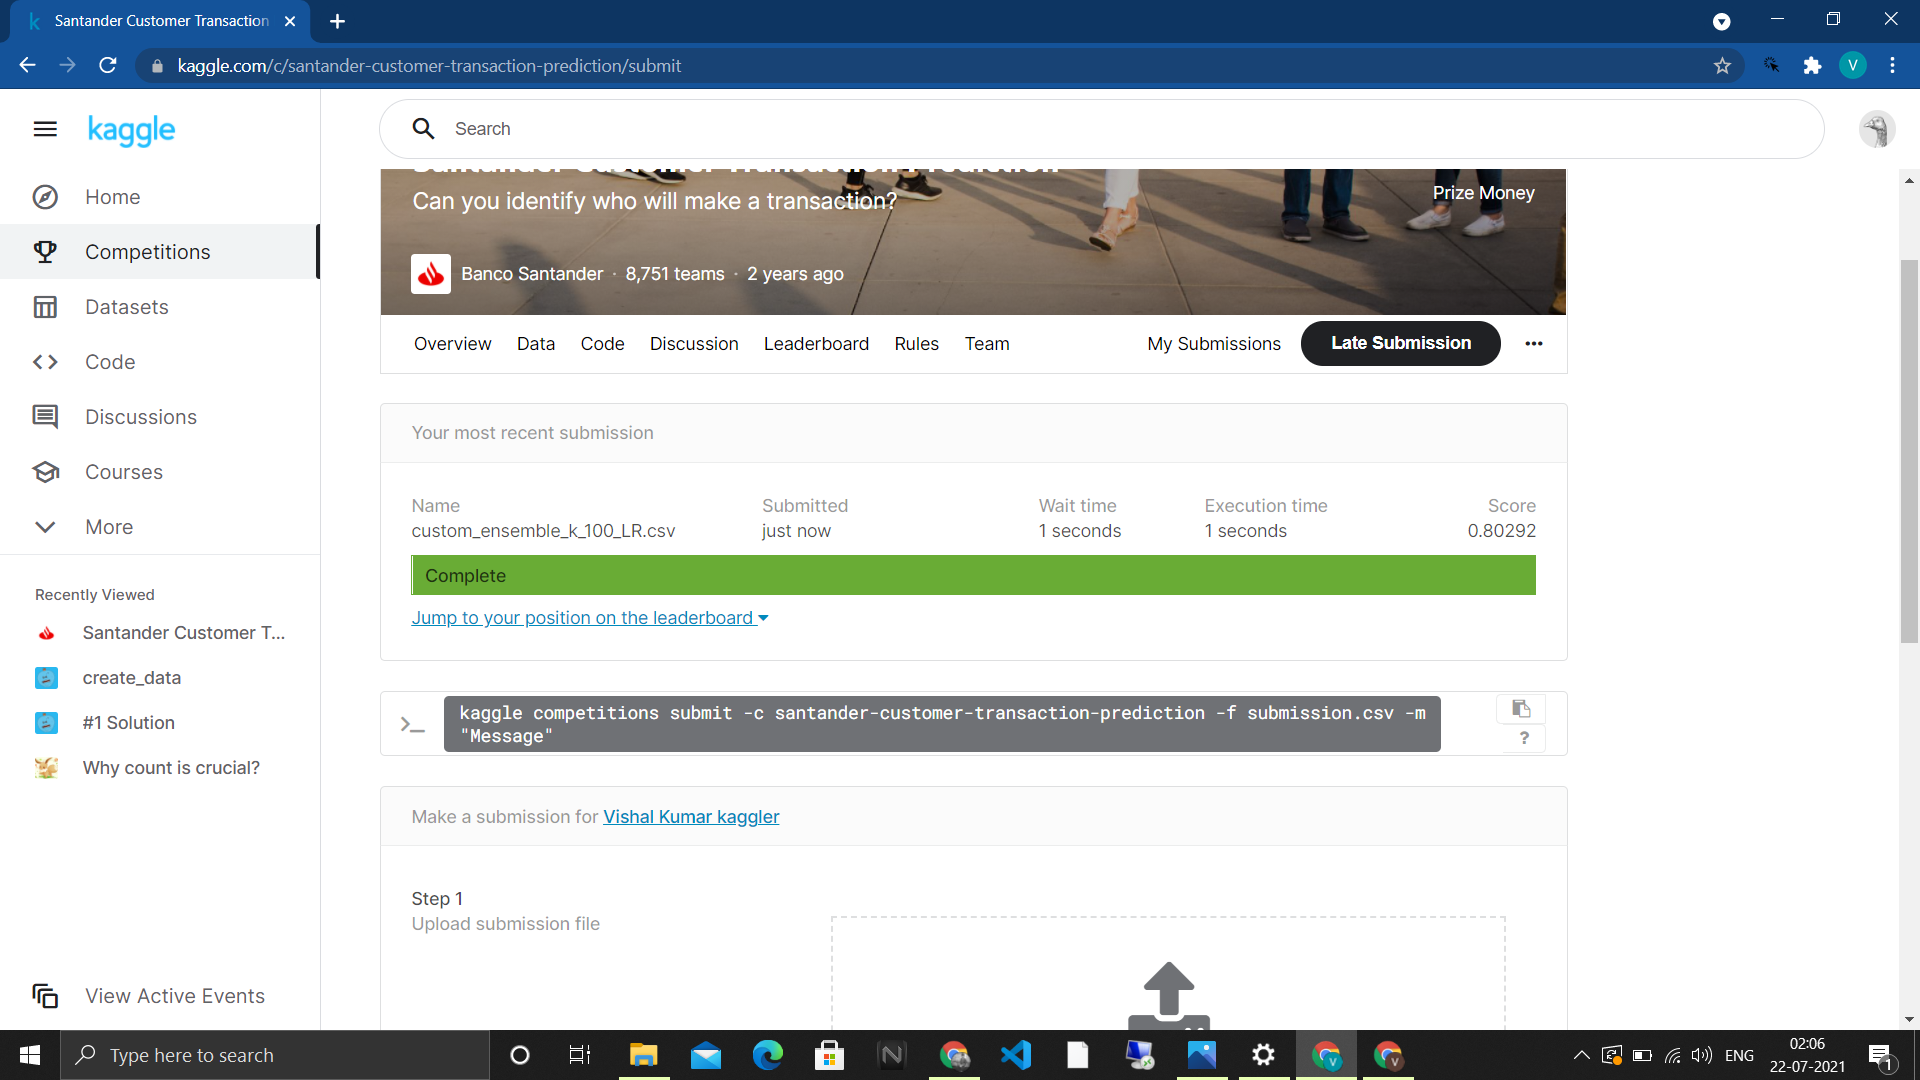

### Custom ensemble model bulding k=200

In [ ]:
clf=DecisionTreeClassifier()

In [ ]:
k=200
fraction=0.3

In [ ]:

pred_score=np.zeros((len(X_d2),k))
pred_score_test=np.zeros((len(X_test),k))
pred_score_submission=np.zeros((len(X_subm),k))
for i in range(k):
  #generating  sample
  X_data=X_d1.sample(frac=fraction)
  Y_data=Y_d1[X_data.index]

  #training
  clf.fit(X_data,Y_data)

  #predicting 
  pred_score[:,i]=clf.predict(X_d2)
  pred_score_test[:,i]=clf.predict(X_test)

  pred_score_submission[:,i]=clf.predict(X_subm)
  



In [ ]:
#meta model =LogisticRegression
clf_meta=LogisticRegression()
clf_meta.fit(pred_score,y_d2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
test_score_label=clf_meta.predict(pred_score_test)
test_score_proba=clf_meta.predict_proba(pred_score_test)[:,1]

auc=roc_auc_score(Y_test,test_score_proba)
print('auc_score:',auc)


cm=confusion_matrix(Y_test, test_score_label)
print('conf_matrix:')
print(cm)


recall=recall_score(Y_test, test_score_label)
print("Recall Score :",recall)

f1=f1_score(Y_test, test_score_label)
print("F1 score Score :",f1)



auc_score: 0.8083541886177783
conf_matrix:
[[35526   454]
 [ 3352   668]]
Recall Score : 0.16616915422885573
F1 score Score : 0.25982108129132636


In [ ]:
test_score_subm=clf_meta.predict_proba(pred_score_submission)[:,1]

ID_code=[f'test_{i}' for i in range(200000)]
d={'ID_code':ID_code,'target':test_score_subm}
submission=pd.DataFrame(data=d)

submission.to_csv("STP_custom_ensemble/custom_ensemble_k_200_LR.csv",index=False)

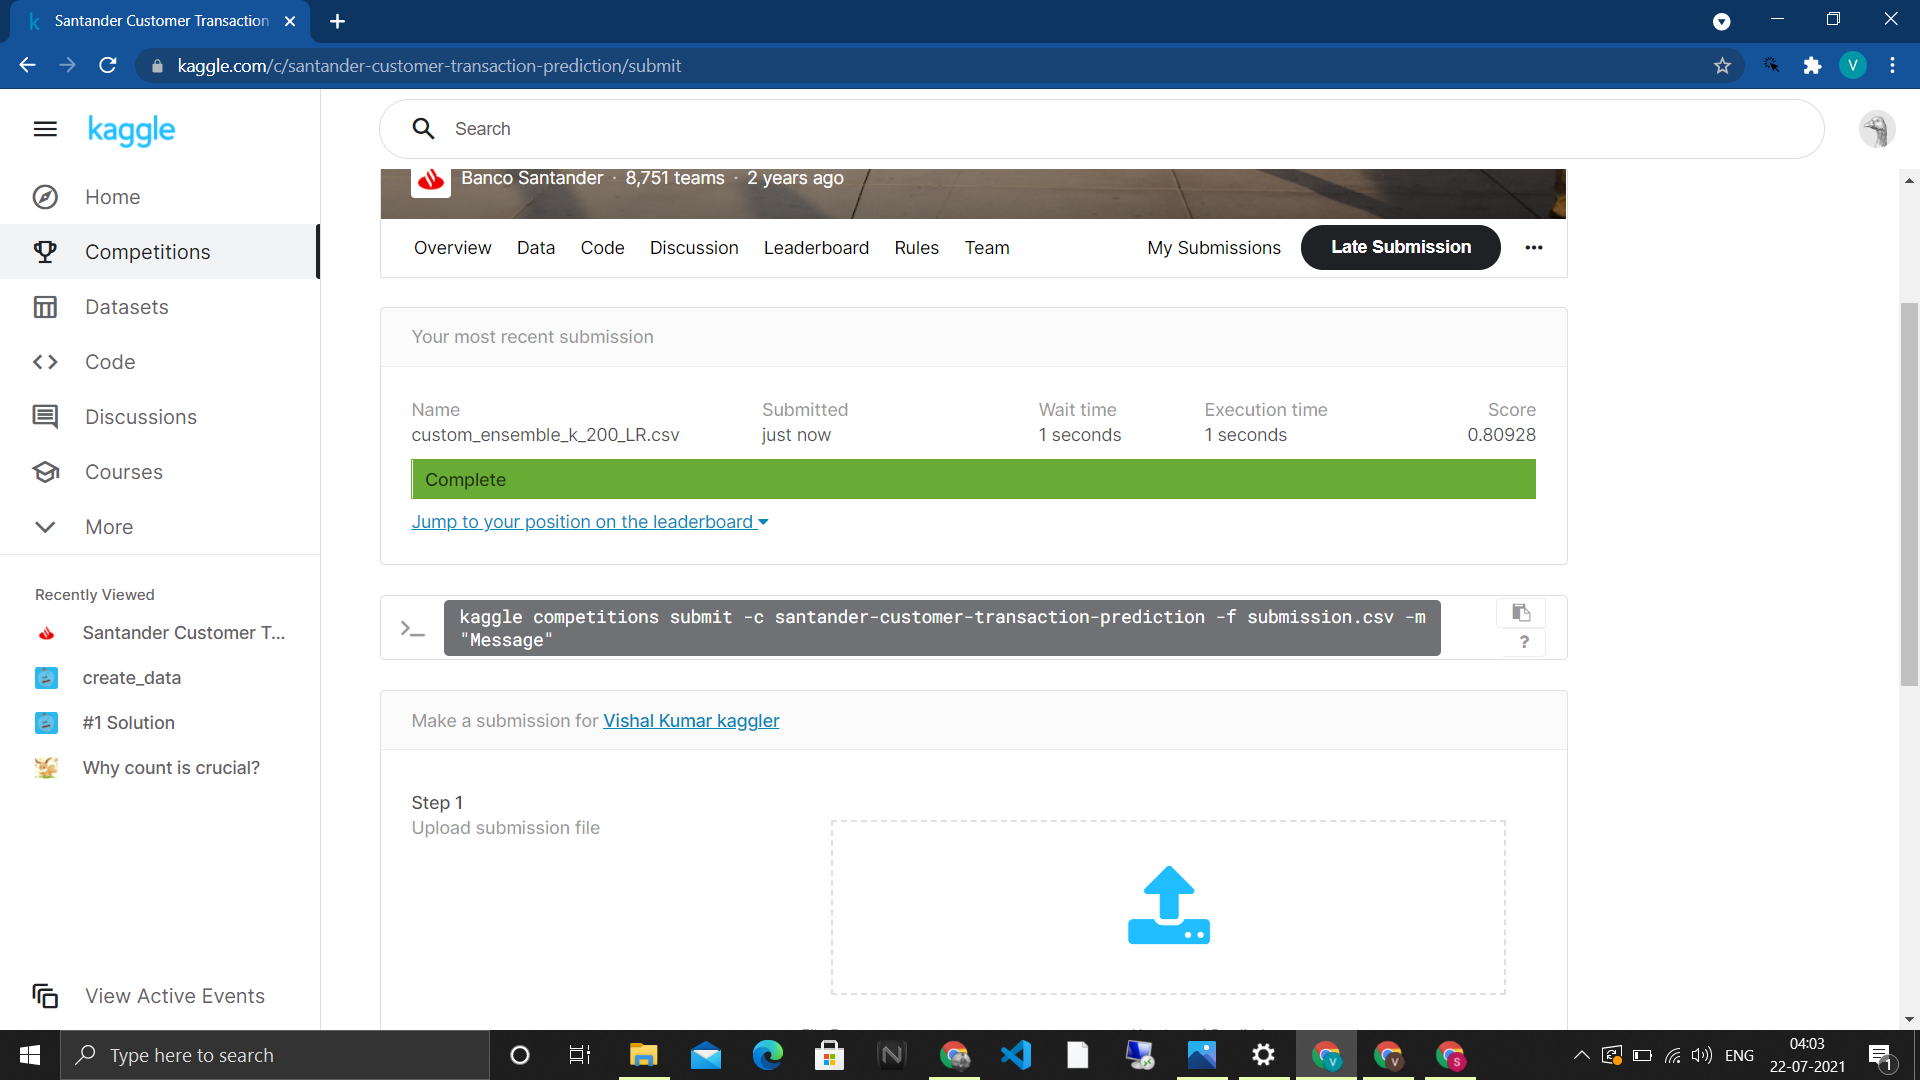

### Custom ensemble model bulding k=300

In [ ]:
clf=DecisionTreeClassifier()

In [ ]:
k=300
fraction=0.3

In [ ]:

pred_score=np.zeros((len(X_d2),k))
pred_score_test=np.zeros((len(X_test),k))
pred_score_submission=np.zeros((len(X_subm),k))
for i in range(k):
  #generating  sample
  X_data=X_d1.sample(frac=fraction)
  Y_data=Y_d1[X_data.index]

  #training
  clf.fit(X_data,Y_data)

  #predicting 
  pred_score[:,i]=clf.predict(X_d2)
  pred_score_test[:,i]=clf.predict(X_test)

  pred_score_submission[:,i]=clf.predict(X_subm)
  



In [ ]:
#meta model =LogisticRegression
clf_meta=LogisticRegression()
clf_meta.fit(pred_score,y_d2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
test_score_label=clf_meta.predict(pred_score_test)
test_score_proba=clf_meta.predict_proba(pred_score_test)[:,1]

auc=roc_auc_score(Y_test,test_score_proba)
print('auc_score:',auc)


cm=confusion_matrix(Y_test, test_score_label)
print('conf_matrix:')
print(cm)


recall=recall_score(Y_test, test_score_label)
print("Recall Score :",recall)

f1=f1_score(Y_test, test_score_label)
print("F1 score Score :",f1)



auc_score: 0.8120152053794397
conf_matrix:
[[35512   468]
 [ 3319   701]]
Recall Score : 0.17437810945273632
F1 score Score : 0.27018693389863174


**Kaggle submission**

In [ ]:
test_score_subm=clf_meta.predict_proba(pred_score_submission)[:,1]

ID_code=[f'test_{i}' for i in range(200000)]
d={'ID_code':ID_code,'target':test_score_subm}
submission=pd.DataFrame(data=d)

submission.to_csv("STP_custom_ensemble/custom_ensemble_k_300_LR.csv",index=False)

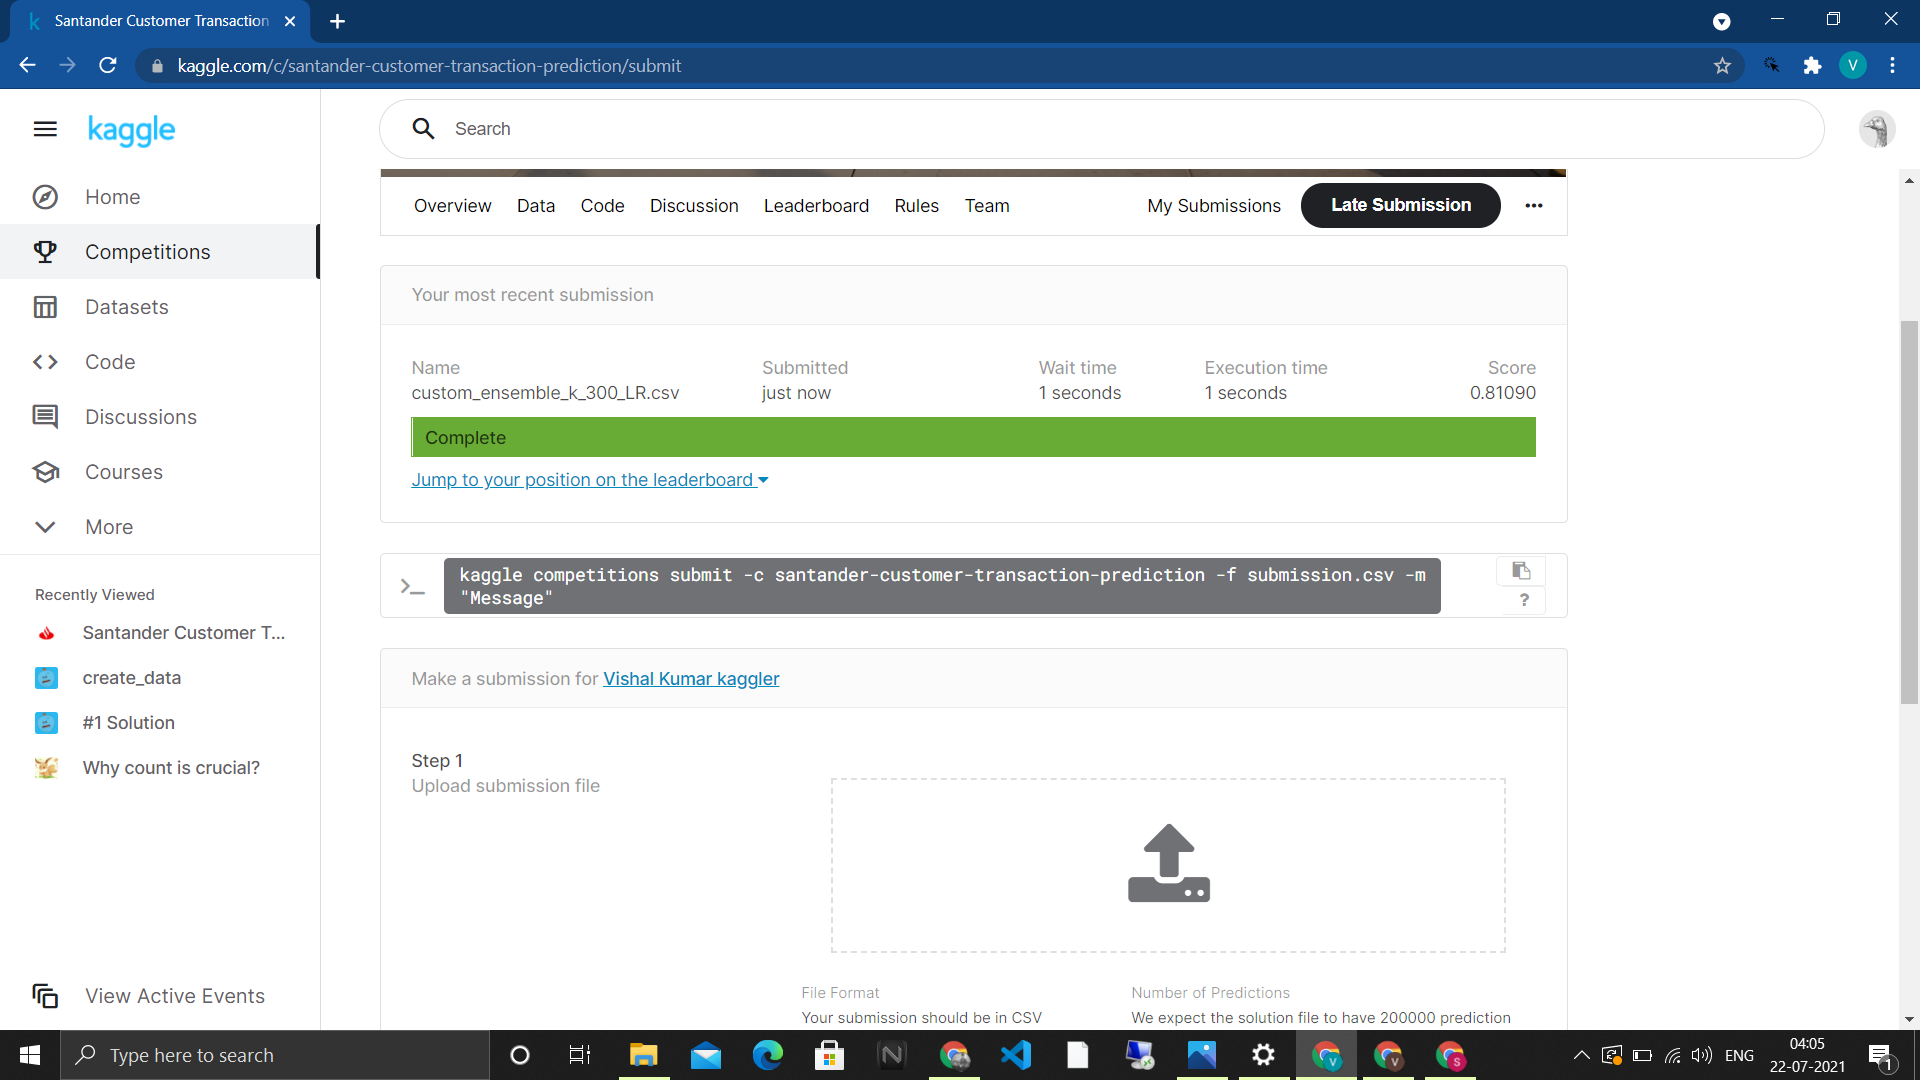

### Custom ensemble model bulding k=500

In [ ]:
clf=DecisionTreeClassifier()

In [ ]:
k=500
fraction=0.3

In [ ]:

pred_score=np.zeros((len(X_d2),k))
pred_score_test=np.zeros((len(X_test),k))
pred_score_submission=np.zeros((len(X_subm),k))
for i in range(k):
  #generating  sample
  X_data=X_d1.sample(frac=fraction)
  Y_data=Y_d1[X_data.index]

  #training
  clf.fit(X_data,Y_data)

  #predicting 
  pred_score[:,i]=clf.predict(X_d2)
  pred_score_test[:,i]=clf.predict(X_test)

  pred_score_submission[:,i]=clf.predict_proba(X_subm)[:,1]


  



In [ ]:
pred_score.shape,pred_score_test.shape,pred_score_submission.shape

((80000, 500), (40000, 500), (200000, 500))

In [ ]:
#meta model =LogisticRegression
clf_meta=LogisticRegression()
clf_meta.fit(pred_score,y_d2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
test_score_label=clf_meta.predict(pred_score_test)
test_score_proba=clf_meta.predict_proba(pred_score_test)[:,1]

auc=roc_auc_score(Y_test,test_score_proba)
print('auc_score:',auc)


cm=confusion_matrix(Y_test, test_score_label)
print('conf_matrix:')
print(cm)


recall=recall_score(Y_test, test_score_label)
print("Recall Score :",recall)

f1=f1_score(Y_test, test_score_label)
print("F1 score Score :",f1)



auc_score: 0.8129365955104965
conf_matrix:
[[35472   508]
 [ 3281   739]]
Recall Score : 0.18383084577114428
F1 score Score : 0.28061515093981393


**Kaggle score**

In [ ]:
test_score_subm=clf_meta.predict_proba(pred_score_submission)[:,1]
 
ID_code=[f'test_{i}' for i in range(200000)]
d={'ID_code':ID_code,'target':test_score_subm}
submission=pd.DataFrame(data=d)
 
submission.to_csv("STP_custom_ensemble/custom_ensemble_k_500_LR.csv",index=False)

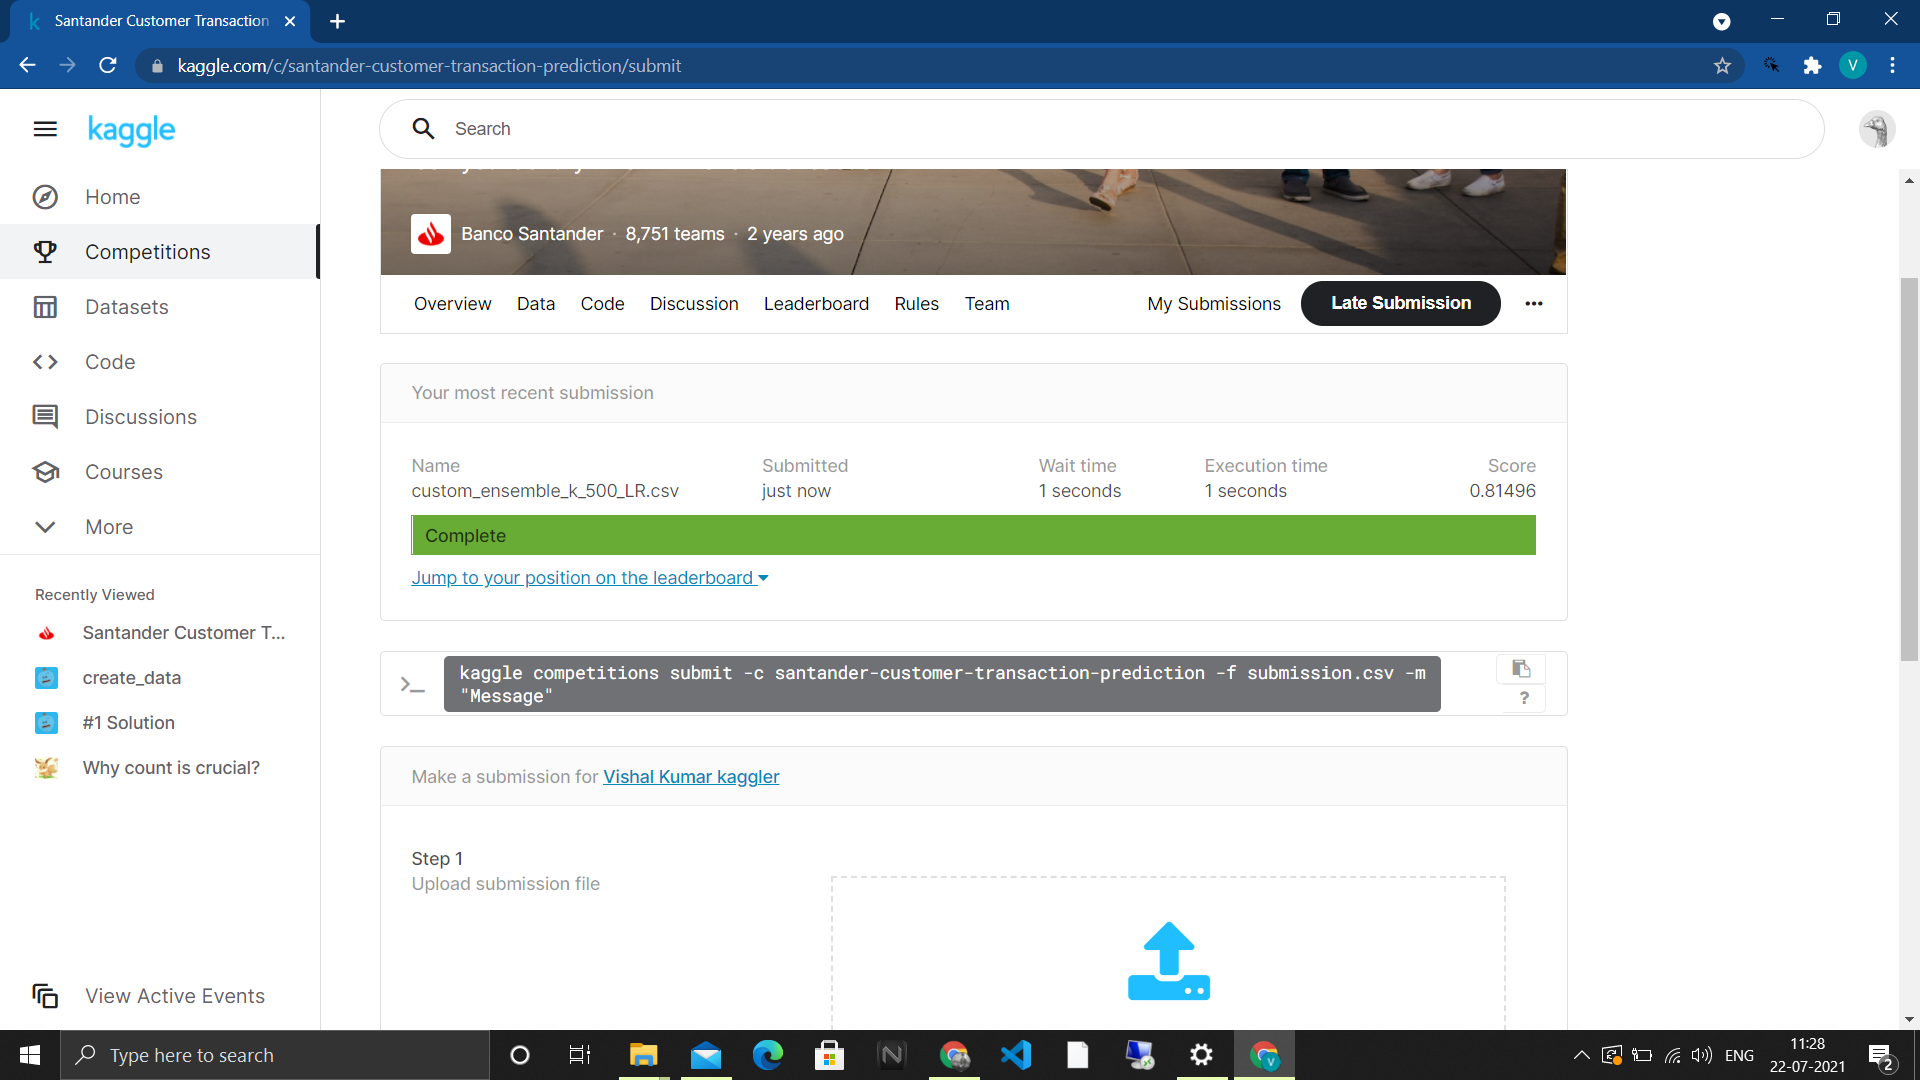